<span style="font-size:30px;">Summary</span>

The size of the data set has 372 rows.

The TSN value is seen as an object and not float.

Found that the Serial number is 187, this is the unique id of the item and there should be multiple values so this fits.

Next I saw that the TSN which should be unique value is 177 which is similar to the Serial number and this is wrong. There should be a lot more unique values.

I check to see what the desperity of the values are for the short text for code, which is the reason it went for repairs. What I found was that majority of 292 are for repairs.

For the TSN I needed to find out why the unique values is so low and the reason was that per Serial Number the TSN value will be the same. I show this on code bracket 11 and 12.

The TSN value that was recorded is the total of all the repairs and not split between them.

By nowing this I created a new table with columns Serial Number, TSN and Number Repair. The Number Repair is the amount of rows thats there for each Serial Number.

Next I need to convert the TSN to a float and in doing that I found that there are UNK values. I decided to remove those values due to not being able to do anything with that value.

The next step was creating the model and the Evaluation for it is below.

In [356]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

<span style="font-size:30px;">Data Understanding</span>


I will first just load all the data and then look at the columns, the size of the data set, the type each column is.

In [357]:
df = pd.read_csv('Project.csv')

In [358]:
df.shape

(372, 10)

In [359]:
df.columns

Index(['Created On', 'Short text for code', 'Item Description',
       'Serial Number', 'A/C Serial No.', 'TAT Cust. Calculated (days)',
       'TAT Supplier calculated (days)', 'Completion by date',
       'TSN Component (Off)(hours)', 'Equipment'],
      dtype='object')

In [360]:
df.dtypes

Created On                         object
Short text for code                object
Item Description                   object
Serial Number                      object
A/C Serial No.                    float64
TAT Cust. Calculated (days)        object
TAT Supplier calculated (days)     object
Completion by date                 object
TSN Component (Off)(hours)         object
Equipment                           int64
dtype: object

Next I want to see what columns have unique values.

In [361]:
df.select_dtypes(include=["object"]).nunique()

Created On                        297
Short text for code                 7
Item Description                    1
Serial Number                     187
TAT Cust. Calculated (days)       172
TAT Supplier calculated (days)    173
Completion by date                234
TSN Component (Off)(hours)        177
dtype: int64

The above data makes sense due to the main component that should not have a lot of unique values which is Short text for code and the Item Description. The Short text for code is the reason it went into repair and the Item Description is the type of item it is.

Take note that there are 372 lines in the dataset, however there are only 187 different Serial Numbers (it's the id), and there are only 177 different TSN Components.

Here I will check what the Unique values are for the columns with the least unique values.

In [362]:
df['Item Description'].unique()

array(['ACTUATOR,SERVO'], dtype=object)

In [363]:
df['Short text for code'].unique()

array(['MODIFICATION', 'REPAIR', 'NO FAULT FOUND', 'WARRANTY', nan,
       'RE-QUALIFICATION', 'INSPECTION / TEST', 'INVESTIGATION'],
      dtype=object)

In [364]:
df.sample(10)

,Created On,Short text for code,Item Description,Serial Number,A/C Serial No.,TAT Cust. Calculated (days),TAT Supplier calculated (days),Completion by date,TSN Component (Off)(hours),Equipment
180,30/03/2021,REPAIR,"ACTUATOR,SERVO",1166,275.0,0,314,17/03/2022,709.90,10788831
47,15/05/2017,REPAIR,"ACTUATOR,SERVO",100,175.0,129,126,21/09/2017,1033.88,10523520
178,17/03/2021,REPAIR,"ACTUATOR,SERVO",1052,219.0,244,208,16/11/2021,1220.00,10551296
227,07/02/2022,REPAIR,"ACTUATOR,SERVO",1190,265.0,263,218,28/10/2022,447.80,10876237
50,06/07/2017,NO FAULT FOUND,"ACTUATOR,SERVO",1052,218.0,129,104,16/11/2017,1220.00,10551296
168,07/01/2021,REPAIR,"ACTUATOR,SERVO",1017,166.0,179,136,11/07/2021,1571.63,10498694
208,07/10/2021,REPAIR,"ACTUATOR,SERVO",1110,229.0,150,131,06/03/2022,1189.00,10702932
61,25/12/2017,NO FAULT FOUND,"ACTUATOR,SERVO",1059,178.0,188,106,02/07/2018,1131.70,10554958
275,13/02/2023,REPAIR,"ACTUATOR,SERVO",1008,157.0,131,76,27/06/2023,1550.45,10494573
231,22/03/2022,NO FAULT FOUND,"ACTUATOR,SERVO",1145,274.0,101,55,01/08/2022,149.80,10759549


Above you can see the first 10 samples of the dataset and this is to gain an idea of the data. The main feature of the dataset is the TSN Component. The unique value for the part is the Serial Number. Short text for code is the reason it went into repair. 

Next I want to see the amount of data for each short text for code. This is to see if there is a large distribution between the values.

In [365]:
df.groupby(['Short text for code'])['Short text for code'].count()

Short text for code
INSPECTION / TEST     10
INVESTIGATION          1
MODIFICATION           8
NO FAULT FOUND        23
RE-QUALIFICATION       1
REPAIR               292
WARRANTY              18
Name: Short text for code, dtype: int64

In the group above we can see that majority of the parts problem was that it needed a repair which is 292, the second most is 23 for No Fault Found. From this I will mostly just focus on the Repair and for now I will not use this to determine the accuracy in the algorithm.

From what we saw before there are only 177 different TSN unique values which is strange with the amount of rows in the data set. I went and inspected the datasheet and from what I saw looking through the excel sheet is that the TSN has the same date for a single serial number. I will show it below.

In [366]:

specific_id = '19'

lines_for_specific_id = df[df['Serial Number'] == specific_id]

lines_for_specific_id

,Created On,Short text for code,Item Description,Serial Number,A/C Serial No.,TAT Cust. Calculated (days),TAT Supplier calculated (days),Completion by date,TSN Component (Off)(hours),Equipment
0,09/07/2013,MODIFICATION,"ACTUATOR,SERVO",19,NaN,106,197,16/10/2013,497.52,10252617
15,11/09/2014,REPAIR,"ACTUATOR,SERVO",19,NaN,0,133,28/05/2015,497.52,10252617
27,12/07/2016,REPAIR,"ACTUATOR,SERVO",19,107.0,"1,087","1,087",20/08/2019,497.52,10252617
350,24/11/2023,REPAIR,"ACTUATOR,SERVO",19,103.0,104,104,NaN,497.52,10252617


In [367]:
lines_for_specific_id = df[df['Serial Number'] == '19']
lines_for_specific_id[['Serial Number', 'TSN Component (Off)(hours)']]

,Serial Number,TSN Component (Off)(hours)
0,19,497.52
15,19,497.52
27,19,497.52
350,19,497.52


<span style="font-size:30px;">Data Preperation</span>

As seen in the example above the TSN is the same for Serial Number 19. Now I did ask the client about this and the answer I got back is that the TSN value that is shown is the total amount of hours the part has flown.

For the next step I am going to make a new data table that will contain the id, TSN, and the number of repairs/changes.

In [368]:
df_new = df[['Serial Number','TSN Component (Off)(hours)']].drop_duplicates(subset = ['Serial Number'], keep = 'first').copy()
df_new = df_new.merge((df['Serial Number'].value_counts()).rename('Number Repair'), left_on='Serial Number', right_index=True)
df_new

,Serial Number,TSN Component (Off)(hours),Number Repair
0,19,497.52,4
1,26,3864.18,2
2,44,999.05,1
3,47,2113.90,2
4,41,3045.10,7
...,...,...,...
358,1014,1707.34,1
359,1084,2046.07,1
362,1106,2105.60,1
365,*00063,355.40,1


The above table is what I will use to determine if I can get a significant accuracy from this table.

Below I will check the number of values that have more than 1 data point
Check the type the columns are
check for unique values

In [369]:
(df_new['Number Repair'] > 1).sum()

95

In [370]:
df_new.dtypes

Serial Number                 object
TSN Component (Off)(hours)    object
Number Repair                  int64
dtype: object

In [371]:
df_new.nunique()

Serial Number                 187
TSN Component (Off)(hours)    177
Number Repair                   8
dtype: int64

I want to convert the TSN to a float because they are all numbers off coarse. but to do this I need to see if there are anything in TSN that will not allow me to change it to float.

In [372]:
numeric_column = pd.to_numeric(df_new['TSN Component (Off)(hours)'], errors='coerce')

non_numeric_values = df_new[pd.isna(numeric_column)]['TSN Component (Off)(hours)']

if not non_numeric_values.empty:
    print("Non-numeric values found in 'your_column':")
    print(non_numeric_values)
else:
    print("No non-numeric values found in 'your_column'")

Non-numeric values found in 'your_column':
14     UNK
17     UNK
204    UNK
239    UNK
247    UNK
276    UNK
298    UNK
299    UNK
Name: TSN Component (Off)(hours), dtype: object


In [373]:
df_new['TSN Component (Off)(hours)'].unique()

array(['497.52', '3864.18', '999.05', '2113.90', '3045.10', '5242.10',
       '2841.40', '1216.22', '492.10', '2730.30', '517.06', '2970.90',
       '3471.90', '2587.40', 'UNK', '4062.50', '1656.40', '4946.80',
       '2460.40', '750.45', '964.00', '812.25', '3924.10', '1521.80',
       '824.60', '1335.95', '1349.80', '4746.60', '3386.40', '1739.10',
       '1087.80', '1033.88', '0.00', '1220.00', '1967.40', '684.77',
       '1853.60', '191.95', '1133.00', '697.68', '1131.70', '997.80',
       '1259.90', '1547.96', '533.06', '577.90', '674.92', '1640.40',
       '694.57', '365.80', '1996.90', '375.00', '1462.30', '1480.80',
       '1017.63', '1194.20', '817.05', '54.20', '1021.50', '1799.60',
       '1551.38', '4283.80', '159.10', '149.80', '958.60', '1874.80',
       '1043.90', '68.90', '1495.31', '1026.62', '1417.55', '1289.20',
       '405.00', '2017.21', '671.60', '868.67', '221.00', '726.10',
       '565.47', '1164.10', '928.20', '769.52', '927.60', '709.90',
       '1897.28', '89

The above two code snipits show the unique value that is in the TSN Component that is not a number. Next I will check the serial number where the value is unkown.

In [374]:
tsn_numeric = pd.to_numeric(df_new['TSN Component (Off)(hours)'], errors='coerce')
invalid_values = df_new[tsn_numeric.isna()]
print("Rows with non-numeric values in 'TSN Component (Off)(hours)':")
print(invalid_values)

Rows with non-numeric values in 'TSN Component (Off)(hours)':
    Serial Number TSN Component (Off)(hours)  Number Repair
14             52                        UNK              4
17         *00069                        UNK              1
204          1087                        UNK              1
239            76                        UNK              1
247        *00060                        UNK              2
276          1092                        UNK              1
298            72                        UNK              1
299            79                        UNK              1


In [375]:
df[df['TSN Component (Off)(hours)'] == 'UNK']

,Created On,Short text for code,Item Description,Serial Number,A/C Serial No.,TAT Cust. Calculated (days),TAT Supplier calculated (days),Completion by date,TSN Component (Off)(hours),Equipment
14,07/08/2014,REPAIR,"ACTUATOR,SERVO",52,143.0,53,49,17/10/2014,UNK,10362467
17,26/11/2014,REPAIR,"ACTUATOR,SERVO",*00069,142.0,114,94,11/06/2015,UNK,10392335
34,13/11/2016,REPAIR,"ACTUATOR,SERVO",52,138.0,0,140,24/05/2017,UNK,10362467
63,08/01/2018,WARRANTY,"ACTUATOR,SERVO",52,129.0,0,119,30/05/2018,UNK,10362467
204,04/10/2021,REPAIR,"ACTUATOR,SERVO",1087,205.0,317,167,17/08/2022,UNK,10590723
238,20/04/2022,REPAIR,"ACTUATOR,SERVO",52,129.0,224,194,30/11/2022,UNK,10362467
239,20/04/2022,REPAIR,"ACTUATOR,SERVO",76,149.0,153,98,20/09/2022,UNK,10404443
247,23/06/2022,REPAIR,"ACTUATOR,SERVO",*00060,133.0,147,105,17/11/2022,UNK,10369438
276,13/02/2023,REPAIR,"ACTUATOR,SERVO",1092,202.0,122,76,18/06/2023,UNK,10604494
298,22/05/2023,REPAIR,"ACTUATOR,SERVO",72,151.0,283,142,29/02/2024,UNK,10398152


From the above I found that there are a few UNK values in the dataset and the only solution I have for these values is to remove them. The reason being that there is no possible way for me to give them a TSN value and I asked the client about this and his response was that it was not recorded.

In [376]:
df_new = df_new[df_new['TSN Component (Off)(hours)'] != 'UNK']

In [377]:
tsn_numeric = pd.to_numeric(df_new['TSN Component (Off)(hours)'], errors='coerce')
invalid_values = df_new[tsn_numeric.isna()]
print("Rows with non-numeric values in 'TSN Component (Off)(hours)':")
print(invalid_values)

Rows with non-numeric values in 'TSN Component (Off)(hours)':
Empty DataFrame
Columns: [Serial Number, TSN Component (Off)(hours), Number Repair]
Index: []


So above i have now removed all the UNK values and next I will make the TSN column a float so that it is easier to use.

In [378]:
df_new['TSN Component (Off)(hours)'] = df_new['TSN Component (Off)(hours)'].astype(float)
df_new.dtypes

C:\Users\jan\AppData\Local\Temp\ipykernel_13100\836761620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['TSN Component (Off)(hours)'] = df_new['TSN Component (Off)(hours)'].astype(float)


Serial Number                  object
TSN Component (Off)(hours)    float64
Number Repair                   int64
dtype: object

Next I am creating a box plot to understand the distribution of the data for each number of repairs

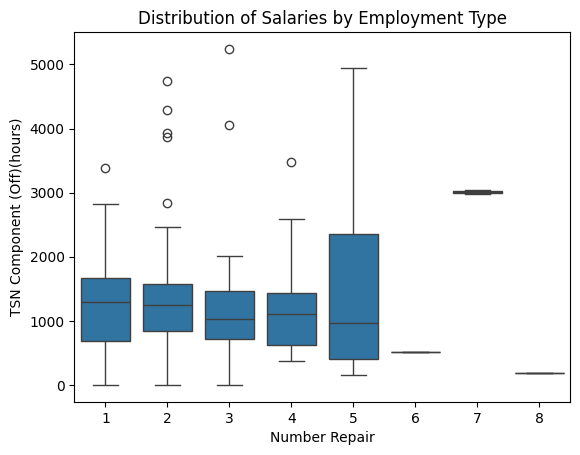

In [379]:
sns.boxplot(data=df_new, x='Number Repair', y='TSN Component (Off)(hours)', order=['1', '2', '3', '4', '5', '6', '7', '8'])

plt.xlabel('Number Repair')
plt.ylabel('TSN Component (Off)(hours)')
plt.title('Distribution of Salaries by Employment Type')

plt.show()

From the box plot above I can see where the median of the values are and it also shows what is consdered outliers for each Number Repair. From this I also learn that the median for is close too each other up until Number Repair 5. For 6, 7, 8 the median and box plot become to small. This means that there mught be a lot of concetrated data or now a lot of different values.

Now I want to visually see what the comparison is between the TSN and the Repair Number. To do this I am going to make a scatter plot to display it.

Text(0.5, 1.0, 'Number Repairs vs TSN')

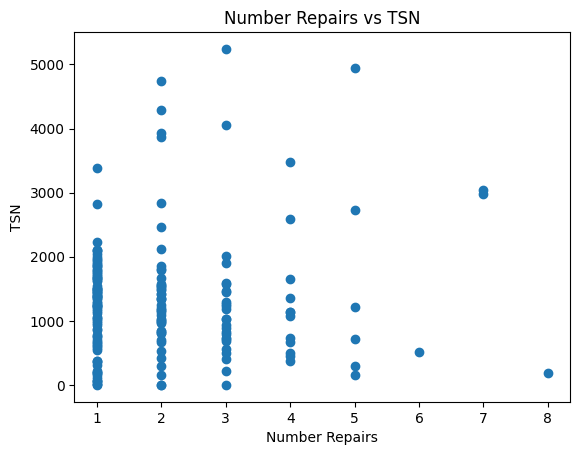

In [380]:
plt.scatter(df_new['Number Repair'], df_new['TSN Component (Off)(hours)'], )


plt.xlabel('Number Repairs')
plt.ylabel('TSN')
plt.title('Number Repairs vs TSN')

Above is to have a better visualization of the data compared to the box plot. This is to give me an understanding of where the data lies and an idea of the amount of points for each Number Repairs. In it I can see that the values for 6, 7, 8 are only 1 dot and this still does not give me a lot of information on those columns.

Next I will show the spread of the values between each Number Repair. This is to get an idea of where most of the data point are and which value will influence the algorithm the most.

In [381]:
df_new['Number Repair'].value_counts()

Number Repair
1    86
2    45
3    26
4    12
5     6
7     2
6     1
8     1
Name: count, dtype: int64

From the information above I can now see that there are a small amount of values in 6, 7, 8. This also shows me that majority of the values are in 1 repair and that it decreases with repairs.

<span style="font-size:30px;">Modeling</span>

In [382]:
features = ["TSN Component (Off)(hours)"]
target = "Number Repair"
X = df_new[features]
y = df_new[target]

In [383]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 179 observations, of which 143 are now in the train set, and 36 in the test set.


In [384]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [385]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
score = accuracy_score(pred, y_test)
print("Accuracy:", score)

Accuracy: 0.4722222222222222


In [386]:
features = ['Number Repair']
target = "TSN Component (Off)(hours)"
X = df_new[features]
y = df_new[target]

In [387]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 179 observations, of which 143 are now in the train set, and 36 in the test set.


In [388]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [389]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
model = KNeighborsRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
score = mean_absolute_error(pred, y_test)
print("Mean Absolute Error::", score)

threshold = score

# Check if predictions are within threshold
accurate_predictions = sum(abs(pred - y_test) <= threshold)
total_predictions = len(y_test)
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Mean Absolute Error:: 865.1588333333334
Accuracy within threshold (865.1588333333334 away): 0.61


<span style="font-size:30px;">Evaluation</span>

From the accuracy that I calculated we can see that the accuracy is really low and on average have a 50% chance of predicting the target variable. I have tested to see if it can predict the amount of repairs the  and then the target variable the TSN which is the number of hours flown. On average from the running the predictions the number of repairs would have an accuracy between 0.4 to 0.5. Now this is not my target variable and is meant to be a test to see how accurate the prediction would be with the data that I have.
Next the accuracy for the target variable TSN average around 0.5 to 0.6. The mosel that I used for it was the Nearest Neigbors Regression model. With this model I had to also found the absolute mean error for the prediction. With the absolute mean error you want to have it as low as possible and currently it is a large number, usually around 800 hours. What that means is that the prediction can be of by around 3 years, knowing that a plane flies around 1 hour a day.

Seen as the accuracies are so low I will begin a new process of creating a model and looking into the data again to see if there are other methods of improving the accuracy.

In [390]:
predictions = model.predict(X_test)

prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = predictions
prediction_overview["error"] = prediction_overview["truth"] - prediction_overview["prediction"]
prediction_overview["error"] = abs(prediction_overview["error"].astype(int))
prediction_overview = prediction_overview.reset_index(drop=True)
prediction_overview

,truth,prediction,error
0,726.10,1896.860,1170
1,1797.37,1350.900,446
2,927.60,1896.860,969
3,301.40,1122.056,820
4,3864.18,1122.056,2742
5,732.50,1282.840,550
6,958.60,1122.056,163
7,1246.40,1350.900,104
8,221.00,1896.860,1675
9,1897.28,1896.860,0


<Axes: xlabel='predicted TSN', ylabel='true TSN'>

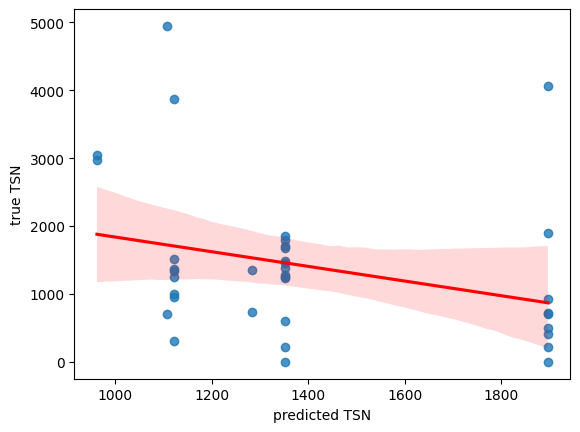

In [391]:
plot = sns.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted TSN")
plot.set_ylabel("true TSN")
plot

In [392]:
me = max_error(y_test, predictions)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

Max Error: 3841
Root Mean Squared Error: 1242


With further inspection of the model we can see that a lot of the values lie outside of the predicted graph especially at the higher predicted values. In the graph you can see that a lot of point lie outside of the predicted area and the error margin. 

With the error shown above I can see that on average the error is 1000 away from the actual. It also shows that is can be up to 3500 away from the actual. This is an indication that the model is lacking and needs more information.

Using the KNN Regression might not fit the moddel with the limited information that it was given. For the next step I will add more data to the datasheet to increase the features that can be selected.

<span style="font-size:30px;">Data Provisioning</span>

Showing the types again as a reminder

In [393]:
df_new.dtypes

Serial Number                  object
TSN Component (Off)(hours)    float64
Number Repair                   int64
dtype: object

In [394]:
df.dtypes

Created On                         object
Short text for code                object
Item Description                   object
Serial Number                      object
A/C Serial No.                    float64
TAT Cust. Calculated (days)        object
TAT Supplier calculated (days)     object
Completion by date                 object
TSN Component (Off)(hours)         object
Equipment                           int64
dtype: object

Here I want to add a new column that will take the amount of days between the date the part went into repair and when it came out. I also saw that there are some that did not have a release date from the repairs yet and for those I used the current date. After finding the date I added them all up per serial number and with that I made a new column called Total Repair Days.

In [395]:
df_change = df.copy()

def convert_date(column):
    try:
        return pd.to_datetime(column, format="%d/%m/%Y", errors='raise')
    except Exception:
        try:
            return pd.to_datetime(column, format="%Y-%m-%d", errors='raise')
        except Exception as e:
            print("Error occurred while converting dates:", e)
            return None

# Convert "Created On" and "Completion by date" columns to datetime
df_change["Created On"] = df_change["Created On"].apply(convert_date)
df_change["Completion by date"] = df_change["Completion by date"].apply(convert_date)

# Define a function to fill NaN values in "Completion by date" with "Created On" + 80 days
def fill_completion_date(row):
    if pd.isna(row["Completion by date"]):
        return row["Created On"] + pd.Timedelta(days=80)
    else:
        return row["Completion by date"]

# Apply the function to fill NaN values
df_change["Completion by date"] = df_change.apply(fill_completion_date, axis=1)

# Drop rows where conversion failed
df_change.dropna(subset=["Created On", "Completion by date"], inplace=True)

# Calculate repair days
df_change["Repair Days"] = (df_change["Completion by date"] - df_change["Created On"]).dt.days

# Group by Serial Number and sum the repair days
total_repair_days = df_change.groupby("Serial Number")["Repair Days"].sum()

# Create a new column "Total Repair Days" in the original Dataset by mapping the total repair days based on serial number
df_new["Total Repair Days"] = df_new["Serial Number"].map(total_repair_days)

df_new

C:\Users\jan\AppData\Local\Temp\ipykernel_13100\1416853031.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Total Repair Days"] = df_new["Serial Number"].map(total_repair_days)


,Serial Number,TSN Component (Off)(hours),Number Repair,Total Repair Days
0,19,497.52,4,1572
1,26,3864.18,2,403
2,44,999.05,1,154
3,47,2113.90,2,228
4,41,3045.10,7,1088
...,...,...,...,...
358,1014,1707.34,1,80
359,1084,2046.07,1,80
362,1106,2105.60,1,80
365,*00063,355.40,1,80


Visually show where the data lies

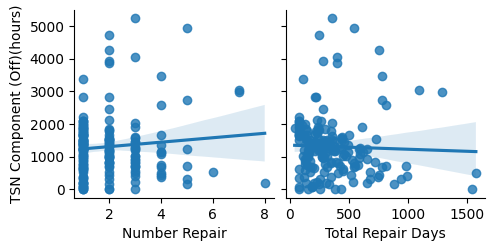

In [396]:
features = ['Number Repair', 'Total Repair Days']
target = 'TSN Component (Off)(hours)'
plot = sns.pairplot(df_new, x_vars=features, y_vars=target, kind="reg")

<span style="font-size:30px;">Model</span>

In [397]:
X = df_new[features]
y = df_new[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

There are in total 179 observations, of which 143 are now in the train set, and 36 in the test set.


In [398]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)

score = mean_absolute_error(pred, y_test)
print("Mean Absolute Error::", score)

threshold = score

# Check if predictions are within threshold
accurate_predictions = sum(abs(pred - y_test) <= threshold)
total_predictions = len(y_test)
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Mean Absolute Error:: 925.2065
Accuracy within threshold (925.2065 away): 0.61


<span style="font-size:30px;">Evaluation</span>

In [399]:
predictions = model.predict(X_test)

prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = predictions
prediction_overview["error"] = prediction_overview["truth"] - prediction_overview["prediction"]
prediction_overview["error"] = abs(prediction_overview["error"].astype(int))
prediction_overview = prediction_overview.reset_index(drop=True)
prediction_overview

,truth,prediction,error
0,192.24,1348.592,1156
1,497.52,877.300,379
2,159.10,1165.816,1006
3,1797.37,1718.864,78
4,4946.80,1268.262,3678
5,1874.80,1173.986,700
6,1164.10,964.646,199
7,1996.90,861.522,1135
8,1707.34,1173.986,533
9,1755.35,1173.986,581


<Axes: xlabel='predicted TSN', ylabel='true TSN'>

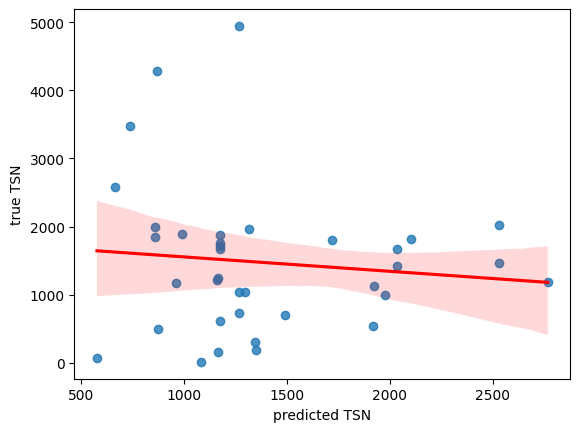

In [400]:
plot = sns.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted TSN")
plot.set_ylabel("true TSN")
plot

In [401]:
me = max_error(y_test, predictions)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

Max Error: 3679
Root Mean Squared Error: 1244


From the new table that was created and the extra data that I used you can see that the accuracy either improves or is similar to the previouse accuracy. The biggest change is the absolute error that decrease by a lot compared to the previouse version which made the prediction much better. From running it multiple times on averegate there are a lot of inconsistancies with the accuracy where it can range from 0.55 to 0.7 and this is better than the previouse version. 

With the error I can also see that on average the mean error is still around 1000. However the Max error has decreased with the lowest being 2100. From the added data I can tell that with both the increase in accuracy and lowering of the error it was a good decision.

<span style="font-size:30px;">Data Preperation</span>

For this itteration I am going to add data for another plane part and see if that will improve the algorithm or work better than the previouse one. I have another data set that has not been used yet. I will now clean the new data and also combine it with the df_new to see if it will change the accuracy.

In [402]:
df_comp = pd.read_csv('Project2.csv')

In [403]:
df_comp.shape

(444, 8)

In [404]:
df_comp.columns

Index(['Created On', 'Short text for code', 'Item Description',
       'Serial Number', 'A/C Serial No.', 'Completion by date',
       'TSN Component (Off)(hours)', 'Equipment'],
      dtype='object')

In [405]:
df_comp.dtypes

Created On                    object
Short text for code           object
Item Description              object
Serial Number                 object
A/C Serial No.                object
Completion by date            object
TSN Component (Off)(hours)    object
Equipment                      int64
dtype: object

In [406]:
df_comp.select_dtypes(include=["object"]).nunique()

Created On                    323
Short text for code             8
Item Description                1
Serial Number                 258
A/C Serial No.                157
Completion by date            226
TSN Component (Off)(hours)    237
dtype: int64

In [407]:
df_comp['Short text for code'].unique()

array([nan, 'REPAIR', 'WARRANTY', 'INSPECTION / TEST', 'BENCHTEST',
       'NO FAULT FOUND', 'MODIFICATION', 'INVESTIGATION', 'RETURN AS IS'],
      dtype=object)

In [408]:
df_comp.groupby(['Short text for code'])['Short text for code'].count()

Short text for code
BENCHTEST              1
INSPECTION / TEST     23
INVESTIGATION          9
MODIFICATION           2
NO FAULT FOUND        98
REPAIR               228
RETURN AS IS           8
WARRANTY              30
Name: Short text for code, dtype: int64

In [409]:
df_comp.sample(10)

,Created On,Short text for code,Item Description,Serial Number,A/C Serial No.,Completion by date,TSN Component (Off)(hours),Equipment
7,21/09/2011,NaN,REMOTE IO CONCENTRATOR,S10770752,132 PC21,17/10/2011,NaN,10405843
336,08/11/2021,REPAIR,REMOTE IO CONCENTRATOR,S12600704,205,17/08/2022,1182.40,10482361
155,23/04/2018,REPAIR,REMOTE IO CONCENTRATOR,S13074083,173,02/08/2018,576.10,10509840
111,25/04/2017,NO FAULT FOUND,REMOTE IO CONCENTRATOR,S13032105,NaN,04/01/2018,252.85,10500814
27,21/05/2013,REPAIR,REMOTE IO CONCENTRATOR,S10740390,136,07/08/2013,511.30,10386090
204,13/06/2019,NO FAULT FOUND,REMOTE IO CONCENTRATOR,S17153962,250,22/11/2019,156.50,10743642
132,19/10/2017,INSPECTION / TEST,REMOTE IO CONCENTRATOR,S11055819,150,14/03/2018,1135.40,10409995
407,09/10/2023,REPAIR,REMOTE IO CONCENTRATOR,S16414821,NaN,NaN,1466.50,10703183
33,16/01/2014,REPAIR,REMOTE IO CONCENTRATOR,S10740390,140,22/05/2014,511.30,10386090
300,18/10/2020,NO FAULT FOUND,REMOTE IO CONCENTRATOR,S17382003,258,07/04/2021,518.80,10792019


In [410]:
df_comp2 = df_comp[['Serial Number','TSN Component (Off)(hours)']].drop_duplicates(subset = ['Serial Number'], keep = 'first').copy()
df_comp2 = df_comp2.merge((df_comp['Serial Number'].value_counts()).rename('Number Repair'), left_on='Serial Number', right_index=True)
df_comp2

,Serial Number,TSN Component (Off)(hours),Number Repair
0,S10740375,NaN,1
1,S10709288,NaN,5
2,S10709287,NaN,10
3,S10709297,NaN,2
4,S10770751,NaN,1
...,...,...,...
437,S17341948,1771.40,1
438,S18139470,1565.70,1
439,S17317846,2495.04,1
440,S17341950,1716.60,1


Next to check if there are any problems with the TSN component and then remove the problem

In [411]:
numeric_column = pd.to_numeric(df_comp2['TSN Component (Off)(hours)'], errors='coerce')

non_numeric_values = df_comp2[pd.isna(numeric_column)]['TSN Component (Off)(hours)']

if not non_numeric_values.empty:
    print("Non-numeric values found in 'your_column':")
    print(non_numeric_values)
else:
    print("No non-numeric values found in 'your_column'")

Non-numeric values found in 'your_column':
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
19     UNK
25     UNK
37     UNK
61     UNK
84     UNK
95     UNK
104    UNK
232    UNK
385    UNK
402    UNK
403    UNK
405    UNK
Name: TSN Component (Off)(hours), dtype: object


seems to be similar problem as before thus I will remove these values

In [412]:
df_comp2 = df_comp2[df_comp2['TSN Component (Off)(hours)'] != 'UNK']

In [413]:
df_comp2 = df_comp2.dropna(subset=['TSN Component (Off)(hours)'])

In [414]:
tsn_numeric = pd.to_numeric(df_comp2['TSN Component (Off)(hours)'], errors='coerce')
invalid_values = df_comp2[tsn_numeric.isna()]
print("Rows with non-numeric values in 'TSN Component (Off)(hours)':")
print(invalid_values)

Rows with non-numeric values in 'TSN Component (Off)(hours)':
Empty DataFrame
Columns: [Serial Number, TSN Component (Off)(hours), Number Repair]
Index: []


Here I change the TSN to a float

In [415]:
df_comp2['TSN Component (Off)(hours)'] = df_comp2['TSN Component (Off)(hours)'].astype(float)
df_comp2.dtypes

Serial Number                  object
TSN Component (Off)(hours)    float64
Number Repair                   int64
dtype: object

In [416]:
df_comp2

,Serial Number,TSN Component (Off)(hours),Number Repair
15,S10740390,511.30,7
17,S10740403,176.30,1
18,S10770721,114.20,1
20,S10709278,1505.00,2
21,S10709279,237.10,1
...,...,...,...
437,S17341948,1771.40,1
438,S18139470,1565.70,1
439,S17317846,2495.04,1
440,S17341950,1716.60,1


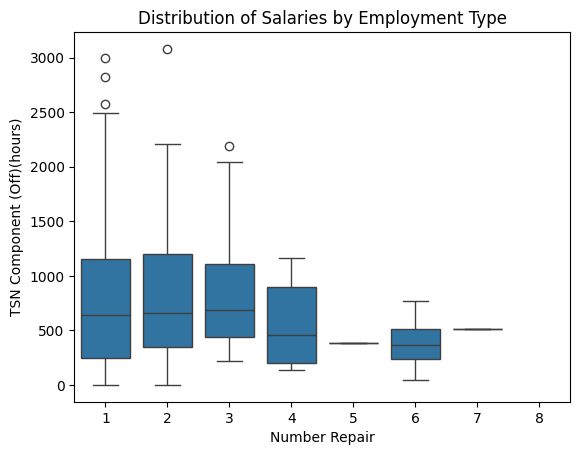

In [417]:
sns.boxplot(data=df_comp2, x='Number Repair', y='TSN Component (Off)(hours)', order=['1', '2', '3', '4', '5', '6', '7', '8'])

plt.xlabel('Number Repair')
plt.ylabel('TSN Component (Off)(hours)')
plt.title('Distribution of Salaries by Employment Type')

plt.show()

Text(0.5, 1.0, 'Number Repairs vs TSN')

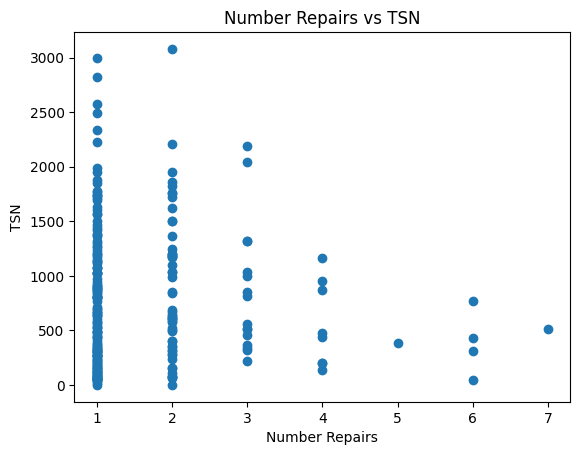

In [418]:
plt.scatter(df_comp2['Number Repair'], df_comp2['TSN Component (Off)(hours)'], )


plt.xlabel('Number Repairs')
plt.ylabel('TSN')
plt.title('Number Repairs vs TSN')

In [419]:
df_comp2['Number Repair'].value_counts()

Number Repair
1    148
2     54
3     16
4      8
6      4
7      1
5      1
Name: count, dtype: int64

Creating a total repair days again

In [420]:
df_change = df_comp.copy()

current_date = datetime.now().date()
df_change["Completion by date"].fillna(current_date, inplace=True)

def convert_date(column):
    try:
        return pd.to_datetime(column, format="%d/%m/%Y", errors='raise')
    except Exception:
        try:
            return pd.to_datetime(column, format="%Y-%m-%d", errors='raise')
        except Exception as e:
            print("Error occurred while converting dates:", e)
            return None

# Convert "Created On" and "Completion by date" columns to datetime
df_change["Created On"] = convert_date(df_change["Created On"])
df_change["Completion by date"] = convert_date(df_change["Completion by date"])

# Drop rows where conversion failed
df_change.dropna(subset=["Created On", "Completion by date"], inplace=True)

# Calculate repair days
df_change["Repair Days"] = (df_change["Completion by date"] - df_change["Created On"]).dt.days

# Group by Serial Number and sum the repair days
total_repair_days = df_change.groupby("Serial Number")["Repair Days"].sum()

# Create a new column "Total Repair Days" in the original Dataset by mapping the total repair days based on serial number
df_comp2["Total Repair Days"] = df_comp2["Serial Number"].map(total_repair_days)

df_comp2

C:\Users\jan\AppData\Local\Temp\ipykernel_13100\4172102738.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_change["Completion by date"].fillna(current_date, inplace=True)


,Serial Number,TSN Component (Off)(hours),Number Repair,Total Repair Days
15,S10740390,511.30,7,1131
17,S10740403,176.30,1,109
18,S10770721,114.20,1,109
20,S10709278,1505.00,2,475
21,S10709279,237.10,1,153
...,...,...,...,...
437,S17341948,1771.40,1,102
438,S18139470,1565.70,1,102
439,S17317846,2495.04,1,86
440,S17341950,1716.60,1,83


The next steps are to combine the two table and to do that I need to add in the name of the part.

In [421]:
df_new = pd.merge(df_new, df[['Serial Number', 'Item Description']], on='Serial Number', how='left')

df_new.rename(columns={'Item Description': 'Type'}, inplace=True)

In [422]:
df_new.sample(10)

,Serial Number,TSN Component (Off)(hours),Number Repair,Total Repair Days,Type
161,1175,68.90,1,192,"ACTUATOR,SERVO"
44,33,3471.90,4,776,"ACTUATOR,SERVO"
340,1072,1580.58,2,243,"ACTUATOR,SERVO"
297,1152,539.00,1,174,"ACTUATOR,SERVO"
159,1068,1874.80,1,42,"ACTUATOR,SERVO"
249,1017,1571.63,3,436,"ACTUATOR,SERVO"
193,1007,769.52,1,131,"ACTUATOR,SERVO"
174,1163,2017.21,3,360,"ACTUATOR,SERVO"
213,1127,836.20,2,345,"ACTUATOR,SERVO"
41,38,2970.90,7,1287,"ACTUATOR,SERVO"


In [423]:
df_comp2 = pd.merge(df_comp2, df_comp[['Serial Number', 'Item Description']], on='Serial Number', how='left')

df_comp2.rename(columns={'Item Description': 'Type'}, inplace=True)

In [424]:
df_comp2.sample(10)

,Serial Number,TSN Component (Off)(hours),Number Repair,Total Repair Days,Type
147,S07290645,3080.44,2,220,REMOTE IO CONCENTRATOR
72,S10709290,999.30,3,401,REMOTE IO CONCENTRATOR
105,S14196482,1320.90,3,551,REMOTE IO CONCENTRATOR
362,S20166535,314.18,1,128,REMOTE IO CONCENTRATOR
86,S13032106,197.90,4,875,REMOTE IO CONCENTRATOR
340,S16414817,1504.90,1,219,REMOTE IO CONCENTRATOR
146,S07338258,2207.66,2,52,REMOTE IO CONCENTRATOR
177,S17028303,221.70,3,746,REMOTE IO CONCENTRATOR
33,S13214140,46.10,6,1052,REMOTE IO CONCENTRATOR
185,S13074070,700.50,1,112,REMOTE IO CONCENTRATOR


In [425]:
(df_comp2['Total Repair Days'] == 0.0).sum()

0

In [426]:
merged_tables = pd.concat([df_new, df_comp2], ignore_index=True)

Now I am adding a new column that will either be a 1 or 2 and depending on the Type name

In [427]:
def map_type_to_numeric(type_str):
    if 'ACTUATOR,SERVO' in type_str:
        return 1
    elif 'REMOTE IO CONCENTRATOR' in type_str:
        return 2
    else:
        return None

merged_tables['Type_numeric'] = merged_tables['Type'].apply(map_type_to_numeric)

In [428]:
merged_tables.sample(10)

,Serial Number,TSN Component (Off)(hours),Number Repair,Total Repair Days,Type,Type_numeric
506,S07338258,2207.66,2,52,REMOTE IO CONCENTRATOR,2
449,S13032106,197.90,4,875,REMOTE IO CONCENTRATOR,2
204,1118,1897.28,3,608,"ACTUATOR,SERVO",1
132,1063,1462.30,3,287,"ACTUATOR,SERVO",1
648,S17317851,807.35,1,160,REMOTE IO CONCENTRATOR,2
729,S17317846,2495.04,1,86,REMOTE IO CONCENTRATOR,2
673,S17001756,796.16,1,169,REMOTE IO CONCENTRATOR,2
485,S14026804,1162.40,4,771,REMOTE IO CONCENTRATOR,2
19,29,2841.40,2,210,"ACTUATOR,SERVO",1
489,S13031966,182.50,1,223,REMOTE IO CONCENTRATOR,2


In [429]:
merged_tables.dtypes

Serial Number                  object
TSN Component (Off)(hours)    float64
Number Repair                   int64
Total Repair Days               int64
Type                           object
Type_numeric                    int64
dtype: object

In [430]:
merged_tables.shape

(732, 6)

In [431]:
merged_tables.nunique()

Serial Number                 411
TSN Component (Off)(hours)    403
Number Repair                   8
Total Repair Days             283
Type                            2
Type_numeric                    2
dtype: int64

<span style="font-size:30px;">Model</span>

In [432]:
predictions = model.predict(df_comp2[['Number Repair', 'Total Repair Days']])

prediction_overview = pd.DataFrame()
prediction_overview["truth"] = df_comp2['TSN Component (Off)(hours)']
prediction_overview["prediction"] = predictions
prediction_overview["error"] = prediction_overview["truth"] - prediction_overview["prediction"]
prediction_overview["error"] = abs(prediction_overview["error"].astype(int))
prediction_overview = prediction_overview.reset_index(drop=True)
prediction_overview

c:\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


,truth,prediction,error
0,511.30,1426.18,914
1,511.30,1426.18,914
2,511.30,1426.18,914
3,511.30,1426.18,914
4,511.30,1426.18,914
...,...,...,...
367,1771.40,1426.18,345
368,1565.70,1426.18,139
369,2495.04,1426.18,1068
370,1716.60,1426.18,290


In [433]:
prediction_overview.mean(axis=0)

truth          762.840376
prediction    1426.180000
error          803.782258
dtype: float64

In [434]:
threshold = mean_absolute_error(predictions, df_comp2['TSN Component (Off)(hours)'])
accurate_predictions = sum(abs(predictions - df_comp2['TSN Component (Off)(hours)']) <= threshold)
total_predictions = len(df_comp2['TSN Component (Off)(hours)'])
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Accuracy within threshold (804.2994623655914 away): 0.45


The top bit was to test how well the previouse prediction would work with the new data and as you can see it has a low percentage of working.

In [435]:
X = df_comp2[features]
y = df_comp2[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

There are in total 372 observations, of which 297 are now in the train set, and 75 in the test set.


In [436]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)

score = mean_absolute_error(pred, y_test)
print("Mean Absolute Error::", score)

threshold = score

# Check if predictions are within threshold
accurate_predictions = sum(abs(pred - y_test) <= threshold)
total_predictions = len(y_test)
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Mean Absolute Error:: 431.8718666666666
Accuracy within threshold (431.8718666666666 away): 0.67


Above is the accuracy for the Computer and here you can see the the absolute mean error is lower than that of the acuator servo.

<span style="font-size:30px;">Evaluation</span>

In [437]:
predictions = model.predict(X_test)

prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = predictions
prediction_overview["error"] = prediction_overview["truth"] - prediction_overview["prediction"]
prediction_overview["error"] = abs(prediction_overview["error"].astype(int))
prediction_overview = prediction_overview.reset_index(drop=True)
prediction_overview

,truth,prediction,error
0,857.50,821.680,35
1,1031.10,1389.100,358
2,94.99,407.000,312
3,873.90,468.300,405
4,459.90,374.220,85
...,...,...,...
70,1774.20,558.232,1215
71,1169.30,1695.860,526
72,957.30,629.700,327
73,555.32,912.292,356


<Axes: xlabel='predicted TSN', ylabel='true TSN'>

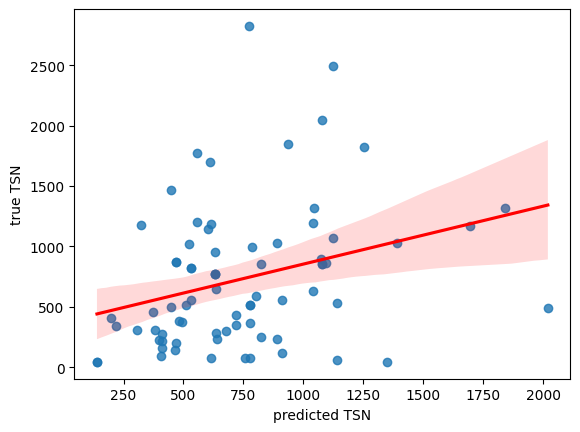

In [438]:
plot = sns.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted TSN")
plot.set_ylabel("true TSN")
plot

In [439]:
me = max_error(y_test, predictions)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

Max Error: 2052
Root Mean Squared Error: 585


With the Computer dataset I can tell that it is alot more linear than the Actuators data. The main indication of it is that the accuracy is higher on averegate compared to the Actuator and the absolute error is alos lower on average. The accuracy also ranges from .59 to .69 depending on the training data.

Next the Max error is lower than the Actuator max error by around 400 and the average mean error is also lower by around 500.

<span style="font-size:30px;">Model</span>

Next I will be testing for the merged tables

In [440]:
features = ["Number Repair", "Total Repair Days", "Type_numeric"]
target = "TSN Component (Off)(hours)"
X = merged_tables[features]
y = merged_tables[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

There are in total 732 observations, of which 585 are now in the train set, and 147 in the test set.


In [441]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)

score = mean_absolute_error(pred, y_test)
print("Mean Absolute Error::", score)

threshold = score

# Check if predictions are within threshold
accurate_predictions = sum(abs(pred - y_test) <= threshold)
total_predictions = len(y_test)
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Mean Absolute Error:: 474.4351700680272
Accuracy within threshold (474.4351700680272 away): 0.66


<span style="font-size:30px;">Evaluation</span>

In [442]:
predictions = model.predict(X_test)

prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = predictions
prediction_overview["error"] = prediction_overview["truth"] - prediction_overview["prediction"]
prediction_overview["error"] = abs(prediction_overview["error"].astype(int))
prediction_overview = prediction_overview.reset_index(drop=True)
prediction_overview

,truth,prediction,error
0,1017.63,1127.746,110
1,55.00,725.880,670
2,1458.28,1260.138,198
3,221.70,465.940,244
4,1565.70,651.374,914
...,...,...,...
142,750.45,1326.306,575
143,958.60,508.680,449
144,1246.40,1021.454,224
145,511.30,418.260,93


<Axes: xlabel='predicted TSN', ylabel='true TSN'>

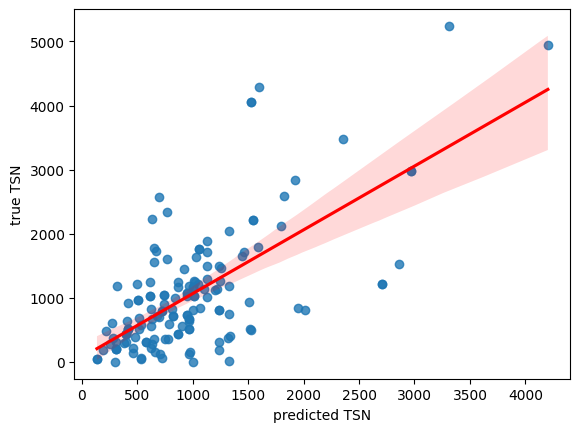

In [443]:
plot = sns.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted TSN")
plot.set_ylabel("true TSN")
plot

In [444]:
me = max_error(y_test, predictions)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

Max Error: 2688
Root Mean Squared Error: 699


Combining the two tables gives by far the best predictions compared to the individual results.
The accuracy for the merged table averages around .6 to .7 with an error margin of around 500. This is a lot better than the previouse results.

The mean error is also low with an average of 600 and the max error is unfortunately high upt to 2800

<span style="font-size:30px;">Model</span>

For this step I will use LR to predict. In the research document that I read this model was the best one to get to the answer that they want.

In [445]:
features = ["Number Repair", "Total Repair Days", "Type_numeric"]
target = "TSN Component (Off)(hours)"
X = merged_tables[features]
y = merged_tables[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 732 observations, of which 585 are now in the train set, and 147 in the test set.


In [446]:

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
lr_pred = lr_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
lr_score = mean_absolute_error(lr_pred, y_test)
print("Linear Regression Mean Absolute Error:", lr_score)

# Check if predictions are within threshold
lr_accurate_predictions = sum(abs(lr_pred - y_test) <= threshold)
lr_accuracy_within_threshold = lr_accurate_predictions / total_predictions
print("Linear Regression Accuracy within threshold ({} away): {:.2f}".format(threshold, lr_accuracy_within_threshold))


Linear Regression Mean Absolute Error: 593.5983733085664
Linear Regression Accuracy within threshold (474.4351700680272 away): 0.56


It is similar to Kneighbors regression

<span style="font-size:30px;">Evaluation</span>

In [447]:
predictions = lr_pred

prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = predictions
prediction_overview["error"] = prediction_overview["truth"] - prediction_overview["prediction"]
prediction_overview["error"] = abs(prediction_overview["error"].astype(int))
prediction_overview = prediction_overview.reset_index(drop=True)
prediction_overview

,truth,prediction,error
0,1967.40,1431.131647,536
1,1198.70,778.002003,420
2,2189.40,719.716953,1469
3,1736.90,843.047572,893
4,565.47,1395.687794,830
...,...,...,...
142,0.00,1359.663287,1359
143,341.70,255.655510,86
144,1417.55,1454.938632,37
145,1508.20,1397.811938,110


<Axes: xlabel='predicted TSN', ylabel='true TSN'>

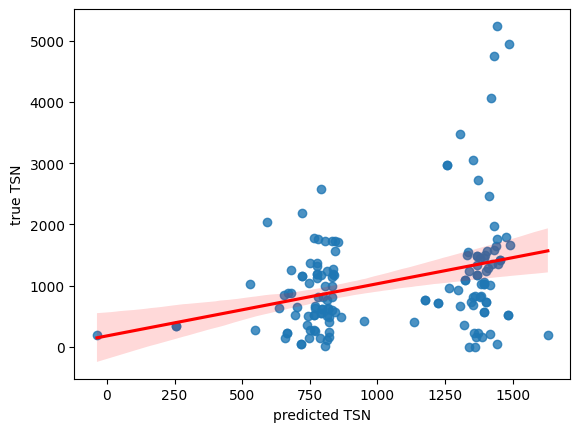

In [448]:
plot = sns.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted TSN")
plot.set_ylabel("true TSN")
plot

In [449]:
me = max_error(y_test, predictions)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

score = mean_absolute_error(predictions, y_test)
print("Mean Absolute Error::", score)

threshold = score

accurate_predictions = sum(abs(predictions - y_test) <= threshold)
total_predictions = len(y_test)
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Max Error: 3801
Root Mean Squared Error: 864
Mean Absolute Error:: 593.5983733085664
Accuracy within threshold (593.5983733085664 away): 0.67


As expected the average error is around 900 and then the max error is around 3200. This is hisher than the previouse result that I have gotten for the models that I used.

<span style="font-size:30px;">Model</span>

From the research that I have done and similar papers, one of the models that were used was the Support Vector Regression(SVR) and I am going to use this next.

In [450]:
from sklearn.svm import SVR

# Load the data
data = merged_tables.copy()

# Separate features and target variable
X = data.drop(['Serial Number', 'TSN Component (Off)(hours)', "Type"], axis=1)
y = data['TSN Component (Off)(hours)']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train SVR model
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = svr.predict(X_train_scaled)
y_pred_test = svr.predict(X_test_scaled)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 874.7314279492647
Test RMSE: 1072.6026558118344


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<span style="font-size:30px;">Evaluation</span>

In [451]:
prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = y_pred_test
prediction_overview["error"] = abs(prediction_overview["truth"] - prediction_overview["prediction"]).astype(int)
prediction_overview

,truth,prediction,error
470,515.00,681.584381,166
689,670.60,825.787868,155
592,341.70,468.298911,126
627,1758.50,771.987848,986
507,3080.44,807.418108,2273
...,...,...,...
487,1169.30,801.552171,367
156,149.80,808.612515,658
432,999.30,748.456063,250
129,1996.90,1050.795907,946


<Axes: xlabel='predicted TSN', ylabel='true TSN'>

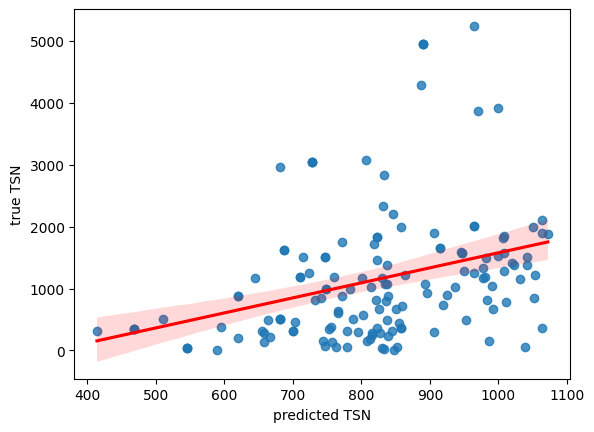

In [452]:
plot = sns.regplot(y=y_test.values.flatten(), x=y_pred_test.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted TSN")
plot.set_ylabel("true TSN")
plot

In [453]:
me = max_error(y_test, y_pred_test)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, y_pred_test)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

score = mean_absolute_error(y_pred_test, y_test)
print("Mean Absolute Error::", score)

threshold = score

accurate_predictions = sum(abs(y_pred_test - y_test) <= threshold)
total_predictions = len(y_test)
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Max Error: 4278
Root Mean Squared Error: 1073
Mean Absolute Error:: 697.6557855129743
Accuracy within threshold (697.6557855129743 away): 0.69


This model has a high accuracy however the Max error and RMSE is also high which makes this model not sootable with the high errors it has. This means I will need to test another model.

<span style="font-size:30px;">Model</span>

Here I want to use a decision tree model to improve the accuracy and see if it will fit with my data. I went with the Random Forest Regressor model.

In [454]:
# Load the data
data = merged_tables.copy()

# Separate features and target variable
X = data.drop(['Serial Number', 'TSN Component (Off)(hours)', 'Type'], axis=1)
y = data['TSN Component (Off)(hours)']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# Predictions
y_pred_train = rf_regressor.predict(X_train)
y_pred_test = rf_regressor.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 263.7623137241863
Test RMSE: 440.41192776357065


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<span style="font-size:30px;">Evaluation</span>

In [455]:
prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = y_pred_test
prediction_overview["error"] = abs(prediction_overview["truth"] - prediction_overview["prediction"]).astype(int)
prediction_overview

,truth,prediction,error
638,351.70,676.764400,325
402,406.58,493.632900,87
623,589.30,707.226500,117
631,1827.80,1701.782733,126
153,149.80,164.890000,15
...,...,...,...
177,671.60,768.780000,97
80,1349.80,1325.952000,23
315,1384.10,397.505802,986
494,294.22,378.990463,84


<Axes: xlabel='predicted TSN', ylabel='true TSN'>

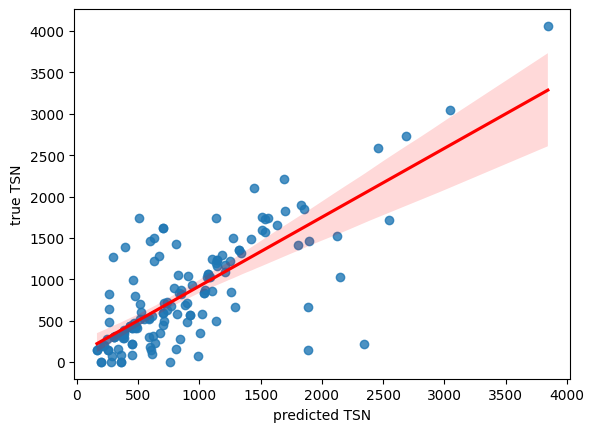

In [456]:
plot = sns.regplot(y=y_test.values.flatten(), x=y_pred_test.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted TSN")
plot.set_ylabel("true TSN")
plot

In [457]:
me = max_error(y_test, y_pred_test)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, y_pred_test)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

score = mean_absolute_error(y_pred_test, y_test)
print("Mean Absolute Error::", score)

threshold = score

accurate_predictions = sum(abs(y_pred_test - y_test) <= threshold)
total_predictions = len(y_test)
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Max Error: 2122
Root Mean Squared Error: 441
Mean Absolute Error:: 273.7380954456695
Accuracy within threshold (273.7380954456695 away): 0.67


This is thus far the best model that I have run. The Max Error is one of the lowest that I have gotten thus far. Next the RSME is also really low at around 500. Next the Absolute error that I got is around 300 and the accuracy is at around 0.68. This model Works really well and will most likely be the final model. However I am going to test two more models that I found or looked at.

<span style="font-size:30px;">Model</span>

Here I am using Gradient Boosting to see if it can improve the accuracy better than the Random Forest Regressor.

In [458]:
from sklearn.ensemble import GradientBoostingRegressor

# Load the data
data = merged_tables.copy()

# Separate features and target variable
X = data.drop(['Serial Number', 'TSN Component (Off)(hours)', 'Type'], axis=1)
y = data['TSN Component (Off)(hours)']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)

# Predictions
y_pred_train = gb_regressor.predict(X_train)
y_pred_test = gb_regressor.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 483.5365266171344
Test RMSE: 608.1934426845048


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<span style="font-size:30px;">Evaluation</span>

In [459]:
prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = y_pred_test
prediction_overview["error"] = abs(prediction_overview["truth"] - prediction_overview["prediction"]).astype(int)
prediction_overview

,truth,prediction,error
102,0.00,1188.898535,1188
220,1068.41,1074.821996,6
718,2338.20,826.735340,1511
730,1716.60,1966.989746,250
342,1361.50,1488.847723,127
...,...,...,...
556,517.70,691.662685,173
424,138.30,406.977676,268
117,1547.96,971.636530,576
264,1234.71,1232.594405,2


<Axes: xlabel='predicted TSN', ylabel='true TSN'>

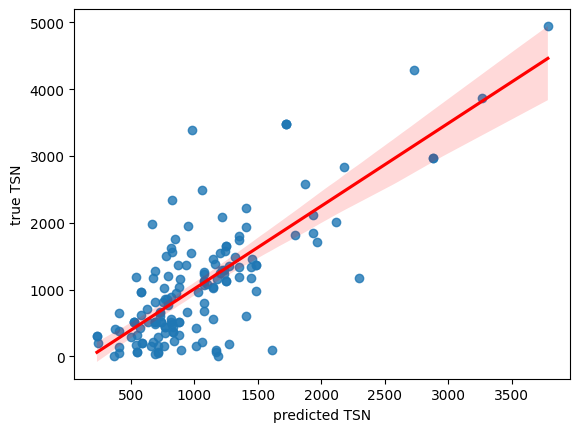

In [460]:
plot = sns.regplot(y=y_test.values.flatten(), x=y_pred_test.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted TSN")
plot.set_ylabel("true TSN")
plot

In [461]:
me = max_error(y_test, y_pred_test)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, y_pred_test)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

score = mean_absolute_error(y_pred_test, y_test)
print("Mean Absolute Error::", score)

threshold = score

accurate_predictions = sum(abs(y_pred_test - y_test) <= threshold)
total_predictions = len(y_test)
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Max Error: 2406
Root Mean Squared Error: 609
Mean Absolute Error:: 429.0339502505573
Accuracy within threshold (429.0339502505573 away): 0.64


This model does not do better than the Random Forest Regression model. It has a higher Max error and the RSME is also higher. The accuracy is a lot similar to the RFR model. I will next test my final model to see the performance on it.

<span style="font-size:30px;">Model</span>

Now I will use the MLP model that was also used in another research document to see how it fairs with my data. In the original document the model did not do as well as the linear regression model and I am looking if it might be better for my data.

In [462]:
from sklearn.neural_network import MLPRegressor

# Load the data
data = merged_tables.copy()

# Separate features and target variable
X = data.drop(['Serial Number', 'TSN Component (Off)(hours)', 'Type'], axis=1)
y = data['TSN Component (Off)(hours)']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train MLP Regressor model
mlp_regressor = MLPRegressor(random_state=42)
mlp_regressor.fit(X_train, y_train)

# Predictions
y_pred_train = mlp_regressor.predict(X_train)
y_pred_test = mlp_regressor.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 1134.672364847259
Test RMSE: 1154.6252836544056


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<span style="font-size:30px;">Evaluation</span>

In [463]:
prediction_overview = pd.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = y_pred_test
prediction_overview["error"] = abs(prediction_overview["truth"] - prediction_overview["prediction"]).astype(int)
prediction_overview

,truth,prediction,error
604,1627.55,448.831695,1178
33,517.06,953.502503,436
300,1430.60,330.905768,1099
457,365.21,731.542948,366
634,1723.40,257.470364,1465
...,...,...,...
70,3924.10,402.778336,3521
192,928.20,195.948288,732
328,103.15,273.448623,170
165,1417.55,281.182982,1136


<Axes: xlabel='predicted TSN', ylabel='true TSN'>

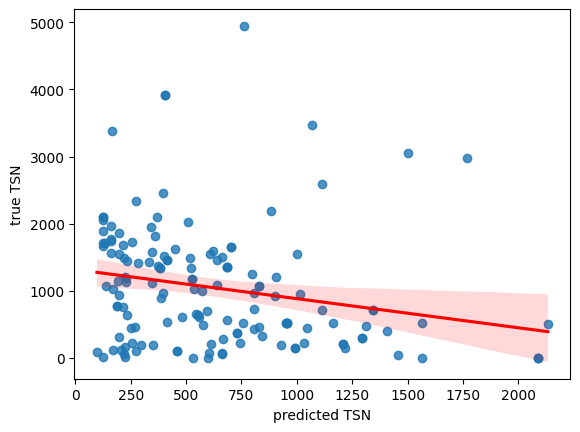

In [464]:
plot = sns.regplot(y=y_test.values.flatten(), x=y_pred_test.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted TSN")
plot.set_ylabel("true TSN")
plot

In [465]:
me = max_error(y_test, y_pred_test)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, y_pred_test)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

score = mean_absolute_error(y_pred_test, y_test)
print("Mean Absolute Error::", score)

threshold = score

accurate_predictions = sum(abs(y_pred_test - y_test) <= threshold)
total_predictions = len(y_test)
accuracy_within_threshold = accurate_predictions / total_predictions
print("Accuracy within threshold ({} away): {:.2f}".format(threshold, accuracy_within_threshold))

Max Error: 4187
Root Mean Squared Error: 1155
Mean Absolute Error:: 896.6145362711427
Accuracy within threshold (896.6145362711427 away): 0.56


As you can see above the Max error is one of the largest errors I have gotten thus far. The RSME is also larger than the previouse models. Even the Mean absolute error and the accuracy is worse then the forest regressor model. Thus I will not use this model.

<span style="font-size:30px;">Conclusion</span>

out of all the models the random forest regressor does the best with the highest accuracy of around 0.7. This this us the best model out of all the models that I have used. Furthermore the RMSE is the lowest compared to all the other models which also helps with making the prediction a lot better. It also has the lowest max error out of all the tests.

In [466]:
data = merged_tables.copy()

# Separate features and target variable
X = data.drop(['Serial Number', 'TSN Component (Off)(hours)', 'Type'], axis=1)
y = data['TSN Component (Off)(hours)']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# Predictions
y_pred_train = rf_regressor.predict(X_train)
y_pred_test = rf_regressor.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 236.90339090605522
Test RMSE: 576.2950641041507


c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Another great thing about this model is that the RMSE for the test and train data is not far apart. This means that there is low varience in the model and that it performs well with different data. The value is also low which means that it gives much more accurate predictions. Generally speaking a RMSE of 200 would be really bad but with the predictions that I am looking at a value of 200 is not as much.

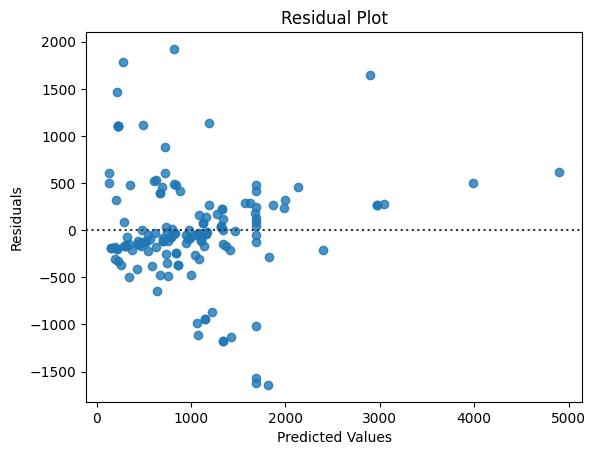

In [467]:
residuals = y_test - y_pred_test

sns.residplot(x = y_pred_test, y = residuals, line_kws=dict(color="r"))
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

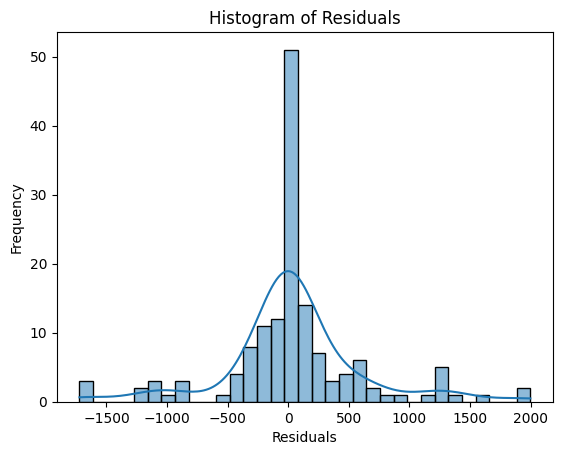

In [468]:
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

The above two graphs shows exactly how far the predictions were estimated from the actual value. As it shows majority of the values lie on 0 or really close to 0 this model will suffice. It would be better if it were more accurate however with the lack of data that I had to work with and can use this is the best I can get for the model.

In [469]:
# Function to calculate the number of days between start and end dates
def calculate_days(start_date, end_date):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    return (end - start).days

# Function to take user inputs and calculate the feature
def calculate_feature(n):
    total_days = 0
    for i in range(1, n+1):
        start_date = input(f"Enter start date for interval {i} (YYYY-MM-DD): ")
        end_date = input(f"Enter end date for interval {i} (YYYY-MM-DD): ")
        print("start date:", start_date, "end date:", end_date)
        days = calculate_days(start_date, end_date)
        print(f"Days between {i}: {days}")
        total_days += days
    print("Total days:", total_days)
    return total_days

In [470]:
X_train.sample(10)

,Number Repair,Total Repair Days,Type_numeric
576,3,594,2
609,2,575,2
354,1,80,1
436,1,158,2
303,3,444,1
251,3,436,1
42,7,1287,1
489,1,223,2
53,3,403,1
342,2,261,1


In [471]:
def Part_Type():
    part = int(input("Enter 1 for Actuator and 2 for Remote IO Concentrator"))
    return part

In [472]:
def predict_output():
    print("Enter values for the following features:")
    
    # Assuming you know the feature names beforehand
    feature_names = ['Number Repair', 'Total Repair Days', 'Type_numeric']
    input_data = {}

    n = int(input("Enter the number of intervals: "))
    print("number of repairs:", n)
    calcdays = calculate_feature(n)
    parttype = Part_Type()
    calcnew = calcdays + int(calcdays/n)
    #print(calcnew)
    input_data[feature_names[0]] = [n]
    input_data[feature_names[1]] = [calcdays]
    input_data[feature_names[2]] = [parttype]

    next_features= ['Number Repair', 'Total Repair Days', 'Type_numeric']
    second_input_data = {}

    next_n = n+1
    second_input_data[next_features[0]] = [next_n]
    second_input_data[next_features[1]] = [calcnew]
    second_input_data[next_features[2]] = [parttype]

    # Convert input data to DataFrame
    input_df = pd.DataFrame(input_data)
    input_df2 = pd.DataFrame(second_input_data)
    # Make prediction
    prediction = rf_regressor.predict(input_df)
    prediction2 = rf_regressor.predict(input_df2)
    # Display the prediction
    print("Predicted Output:", prediction[0])

# Example usage
predict_output()

Enter values for the following features:


ValueError: invalid literal for int() with base 10: '1.1'